<a href="https://colab.research.google.com/github/rodrigoclira/mineracao-dados/blob/main/Selecao_de_Atributos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Seleção de Atributos

Usamos seleção de atributos para escolher aqueles que sejam úteis ao modelo. Atributos irrelevantes podem causar um efeito negativo. Atributos correlacionados podem deixar os coeficientes das regressões instáveis ou difícieis de interpretar. 

A maldição da dimensionalidade é outra questão a ser considerada. À medida que você aumenta o número de dimensões de seus dados, eles se tornarão mais esparsos. Isso pode dificultar a obtenção de um sinal, a menos que você tenha mais dados. Cálculos de vizinhanças tendem a perder a utilidade a medida que mais dimensões são adicionadas. 

Além disso, o tempo para treinamento dos dados em geral é uma função do número de colunas. Se você conseguir ser conciso e preciso com suas colunas, será possível obter um modelo melhor em menos tempo. Descrevendo alguns exemplos usando conjunto de dados. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

In [ ]:
url = "https://github.com/rodrigoclira/mineracao-dados/blob/main/datasets/titanic3.xls?raw=true"
df = pd.read_excel(url)
orig_df = df

podemos agregar dados de cabine (idade máxima por cabine, idade média por cabine etc.). Para obter dados agregados por cabine, utilize o método .groupby do pandas para criá-los

In [ ]:
df.groupby("cabin").agg("min,max,mean,sum".split(",")).reset_index()

In [ ]:
agg = (df.groupby("cabin")
     .agg("min,max,mean,sum".split(","))
     .reset_index())

agg.columns = [
     "_".join(c).strip("_")
     for c in agg.columns.values
]

agg_df = df.merge(agg, on="cabin")
agg_df

In [ ]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

Colunas colineares

In [ ]:
limit = 0.95 #correlação 

corr = agg_df.corr()
mask = np.triu(
    np.ones(corr.shape), k=1
).astype(bool)
corr_no_diag = corr.where(mask)
coll = [
    c
    for c in corr_no_diag.columns
    if any(abs(corr_no_diag[c]) > limit)
]
coll

O pacote rfpimp (https://oreil.ly/MsnXc) tem um recurso de visualização de
multicolinearidade. A função plot_dependence_heatmap faz o treinamento de uma
floresta aleatória (random forest) para cada coluna numérica a partir das
outras colunas em um conjunto de dados de treinamento. O valor da
dependência é a pontuação R2 das estimativas OOB (Out-Of-Bag) para a
predição dessa coluna

In [ ]:
!pip install rfpimp

In [ ]:
import rfpimp
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(X_train),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(8, 8)
)
fig = plt.gcf()


A forma sugerida de usar esse gráfico é encontrar valores próximos de 1. O 
rótulo no eixo X é o atributo que faz a predição do rótulo do eixo Y. Se um
atributo faz a predição de outro, podemos remover o atributo previsto (o
atributo no eixo Y). Em nosso exemplo, fare faz a predição de pclass, sibsp, parch e embarked_Q. Poderemos manter fare e remover os demais atributos, obtendo
um desempenho semelhante

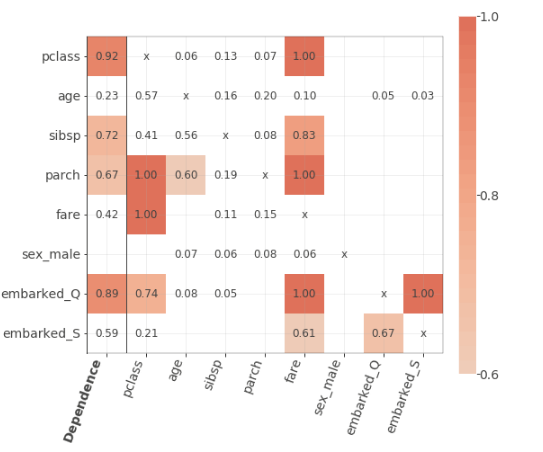

In [ ]:
from sklearn.ensemble import RandomForestClassifier

cols_to_remove = [
    "fare",
    "sibsp",
    "parch",
    "embarked_Q",
]

rf3 = RandomForestClassifier(random_state=20)
rf3.fit(
    X_train[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_train,
)

rf3.score(
    X_test[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_test,
)


In [ ]:
rf4 = RandomForestClassifier(random_state=20)
rf4.fit(X_train, y_train)
rf4.score(X_test, y_test)

#Eliminação Recursiva de atributos

A eliminação recursiva de atributos removerá os atributos mais fracos, e
então fará a adequação de um modelo. Fazemos isso passando um modelo do scikit-learn com um atributo .coef_ ou .feature_importances_:

In [ ]:
from yellowbrick.features import RFECV
fig, ax = plt.subplots(figsize=(12, 8))
rfe = RFECV(
    ensemble.RandomForestClassifier(
        n_estimators=100, random_state=20
    ),
    cv=5,
)
rfe.fit(X, y)
print(rfe.rfe_estimator_.ranking_)
print(rfe.rfe_estimator_.n_features_)
print(rfe.rfe_estimator_.support_)
rfe.poof()

Usaremos a eliminação recursiva de atributos para encontrar os dez atributos
mais importantes. (Nesse conjunto de dados agregados, vimos que há
vazamento da coluna de sobrevivência!)

In [ ]:
from sklearn.feature_selection import RFE
model = ensemble.RandomForestClassifier(
    n_estimators=100
)
rfe = RFE(model, n_features_to_select = 5)
rfe.fit(X, y)
X.columns[rfe.support_]

https://towardsdatascience.com/5-feature-selection-method-from-scikit-learn-you-should-know-ed4d116e4172

https://scikit-learn.org/stable/modules/feature_selection.html